# Linked Data con Python

Master Data Science 2020-2021.



Andrea Celis González

## Cargamos el entorno

In [1]:
import sys
from gastrodon import RemoteEndpoint,QName,ttl,URIRef,inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from IPython.display import display, HTML
pd.options.display.width=120
pd.options.display.max_colwidth=100

Definimos los prefijos que de los "namespace" a utilizar

In [2]:
prefixes=inline("""
    @prefix : <http://dbpedia.org/resource/> .
    @prefix dbp: <http://dbpedia.org/ontology/> .
    @prefix pr: <http://dbpedia.org/property/> .
    @prefix foaf: <http://xmlns.com/foaf/0.1/> .
""").graph

Y el endpoint sobre el que vamos a hacer las consultas. En este caso, dbpedia.

In [3]:
endpoint=RemoteEndpoint(
    "http://dbpedia.org/sparql/"
    ,default_graph="http://dbpedia.org"
    ,prefixes=prefixes
    ,base_uri="http://dbpedia.org/resource/"
)

# Ejercicios de consultas

<div class="alert alert-warning" role="alert" style="margin: 10px">
La librería a veces tiene problemas con las fechas. Si es así, colocal la consulta en el endpoint directamente para comprobar que si el problema está en la consulta o en el paquete.
</div>

**1. Obtener la masa de 10 estrellas.**

In [262]:
estrellas = endpoint.select("""


SELECT DISTINCT ?name ?mass
WHERE{

    ?star a dbp:Star .
    ?star foaf:name ?name .
    ?star pr:mass ?mass .
}

GROUP BY ?name ?mass
LIMIT 10

""")
estrellas

,
name,mass
MY Apodis,0.71
UScoCTIO 108A,0.057
υ Andromedae,0.2
V1429 Aql,26.26
V337 Carinae,9
V382 Carinae,20
V718 Persei,1.6
V810 Cen A/B,20
δ Andromedae,~1.3


**2. Constelación a la que pertenece cada estrella.**

In [263]:
constelacion = endpoint.select("""

SELECT DISTINCT ?name ?constell
WHERE{

    ?star a dbp:Star .
    ?star foaf:name ?name .
    ?star pr:mass ?mass .
    ?star pr:constell ?constell .
}

GROUP BY ?name ?mass
LIMIT 10


""")
constelacion

,name,constell
0,Luhman 16,<Vela_(constellation)>
1,Lupus-TR-3,<Lupus_(constellation)>
2,Luyten 726-8 A/B,<Cetus>
3,M33 X-7,<Triangulum>
4,MOA-2007-BLG-192L,<Sagittarius_(constellation)>
5,MX Puppis,<Puppis>
6,MY Camelopardalis,<Camelopardalis>
7,υ Carinae,<Carina_(constellation)>
8,υ Leonis,<Leo_(constellation)>
9,Upsilon Ursae Majoris,<Ursa_Major>


**3. Distancia a la que está la estrella Kepler-19.**

In [266]:
dist_kepler = endpoint.select("""

SELECT ?name ?distancia
WHERE{
    ?star a dbp:Star .
    ?star foaf:name ?name .
    ?star pr:parallax ?distancia .
    FILTER contains(lcase(str(?name)), "kepler-19") 
} 
LIMIT 10
""")

dist_kepler

,name,distancia
0,Kepler-19,4


**4. Estrellas pertenecientes a la constelación Centaurus**

In [268]:
star_centaurus = endpoint.select("""

SELECT DISTINCT ?star 
WHERE{
    ?star a dbp:Star .
    ?star pr:constell ?constell .
    FILTER contains(lcase(str(?constell)), "centaurus") 
} 

""")

star_centaurus

,star
0,<M_Centauri>
1,<Upsilon1_Centauri>
2,<Upsilon2_Centauri>
3,<V1400_Centauri>
4,<V744_Centauri>
...,...
118,<X1_Centauri>
119,<X2_Centauri>
120,<Xi1_Centauri>
121,<Xi2_Centauri>


**5. Obtener la población total de Londres**

In [4]:
pop_london = endpoint.select("""

SELECT ?city ?population 

WHERE{
    ?city dbo:type dbr:Capital_city .
    ?city pr:populationTotal ?population .
    FILTER contains(lcase(str(?city)), "london") 
} 

LIMIT 10
""")

pop_london

,city,population
0,<London>,8961989


**6. Gente que nació en Londres antes de 1900**

In [204]:
#Se contemplan dos posibilidades; las personas con bithPlace en Londres y personas con bithPlace en barrios de Londres.

pers_london = endpoint.select("""

SELECT DISTINCT ?person ?place ?region

WHERE{

    ?person a foaf:Person .
    ?person dbp:birthDate ?date . 
    
    
    {?person dbp:birthPlace ?place . ?place pr:region ?region .
    FILTER contains(lcase(str(?region)), "london" ) .
    }
    UNION
    {?person dbp:birthPlace ?place . FILTER (?place=<http://dbpedia.org/resource/London> ) .}


    FILTER (?date < "1900-01-01"^^xsd:date) . 
}

""")

pers_london

,person,place,region
0,<Billy_Moon>,<Maida_Vale>,London
1,"<George_Harrison_(cricketer,_born_1860)>",<Maida_Vale>,London
2,<Dora_Tulloch>,<Maida_Vale>,London
3,<Lancelot_Cayley_Shadwell>,<Maida_Vale>,London
4,<Leslie_Green>,<Maida_Vale>,London
...,...,...,...
4063,<F._Percy_Smith>,<London>,None
4064,<H._A._Prichard>,<London>,None
4065,<William_Harold_Hutt>,<London>,None
4066,<Lewis_Levy>,<London>,None


**7. Nombre y fechas de nacimiento y de muerte de toda la gente nacida en Londres entre 1900 y 1950.**

In [206]:
#Se prueba la consulta en SPARQL Query Editor y se comprueba que funciona. El error se debe al paquete.
pers2_london = endpoint.select(""" 

SELECT ?person ?date ?death

WHERE{

    ?person a foaf:Person .
    ?person dbp:birthDate ?date . 
    
    {?person dbp:birthPlace ?place . ?place pr:region ?region .
    FILTER contains(lcase(str(?region)), "london" ) .
    }
    UNION
    {?person dbp:birthPlace ?place . FILTER (?place=<http://dbpedia.org/resource/London> ) .}
    

    OPTIONAL { ?person dbp:deathDate ?death . } 
    
    FILTER ((?date >= "1900-01-01"^^xsd:date) && 
             (?date < "1950-01-01"^^xsd:date)) .

}

""")

pers2_london

,person
0,<Jean_Simmons>
1,<Val_Guest>
2,<Alan_Turing>
3,<Alec_Guinness>
4,<Terence_Fisher>
...,...
5251,<Tony_Lawrence>
5252,<Tony_Selby>
5253,<Tony_Stevens>
5254,<Reg_Routledge>


**8. Nombre y fecha de nacimiento de los actores nacidos en Londres después de 1930 que siguen vivos.**

In [213]:
#Se prueba la consulta en SPARQL Query Editor y se comprueba que funciona. El error se debe al paquete.
pers2_london = endpoint.select(""" 

SELECT ?person ?date

WHERE{

    ?person a foaf:Person .
    ?person dbp:birthDate ?date . 
    
    {?person dbp:birthPlace ?place . ?place pr:region ?region .
    FILTER contains(lcase(str(?region)), "london" ) .
    }
    UNION
    {?person dbp:birthPlace ?place . FILTER (?place=<http://dbpedia.org/resource/London> ) .}
    
    
    ?person dbp:occupation <http://dbpedia.org/resource/Actor> .
    
    
    FILTER (?date >= "1930-01-01"^^xsd:date) .
    
    FILTER NOT EXISTS { ?person dbp:deathDate ?death . } 

}

""")

pers2_london

,person
0,<Dominic_Cooper>
1,<Dominic_Power>
2,<Blake_Harrison>
3,<Velile_Tshabalala>
4,<Graham_Cole>
...,...
245,<Tim_Marriott>
246,<Timothy_Ackroyd>
247,<Tolga_Safer>
248,<Tony_O'Callaghan>


**9. Fotos de 10 de los actores nacidos en Londres después de 1930 que siguen vivos.**

In [214]:
foto_london = endpoint.select(""" 

SELECT ?person ?foto

WHERE{

    ?person a foaf:Person .
    ?person dbp:birthDate ?date . 
    
    {?person dbp:birthPlace ?place . ?place pr:region ?region .
    FILTER contains(lcase(str(?region)), "london" ) .
    }
    UNION
    {?person dbp:birthPlace ?place . FILTER (?place=<http://dbpedia.org/resource/London> ) .}
    
    
    ?person dbp:occupation <http://dbpedia.org/resource/Actor> .
    ?person foaf:depiction ?foto
    
    FILTER (?date >= "1930-01-01"^^xsd:date) .
    
    FILTER NOT EXISTS { ?person dbp:deathDate ?death . } 

}

limit 10
""")

foto_london

,person,foto
0,<Dominic_Cooper>,http://commons.wikimedia.org/wiki/Special:FilePath/Dominic_Cooper_by_Gage_Skidmore.jpg
1,<Blake_Harrison>,http://commons.wikimedia.org/wiki/Special:FilePath/Blake_Harrison_2009.jpg
2,<Graham_Cole>,http://commons.wikimedia.org/wiki/Special:FilePath/GrahamCole.JPG
3,<Derek_Ramsay>,http://commons.wikimedia.org/wiki/Special:FilePath/Derek_Ramsay_at_the_KC_Concepcion_Live_Concer...
4,<Blake_Ritson>,http://commons.wikimedia.org/wiki/Special:FilePath/Blake_Ritson.PNG
5,<Dominic_Cooper>,http://commons.wikimedia.org/wiki/Special:FilePath/Dominic_Cooper_by_Gage_Skidmore.jpg
6,<Graham_Cole>,http://commons.wikimedia.org/wiki/Special:FilePath/GrahamCole.JPG
7,<Charlie_G._Hawkins>,http://commons.wikimedia.org/wiki/Special:FilePath/Charlie_G_Hawkins.jpg
8,<Alfred_Molina>,http://commons.wikimedia.org/wiki/Special:FilePath/AlfredMolinaByJustinHoch2009.jpg
9,<Alfred_Molina>,http://commons.wikimedia.org/wiki/Special:FilePath/AlfredMolinaByJustinHoch2009.jpg


In [223]:
HTML('<img src="{0}">'.format(foto_london.at[0,'foto']))

In [222]:
HTML('<img src="{0}">'.format(foto_london.at[1,'foto']))

**10 . Histograma de las 10 peliculas más largas**

In [250]:
movie = endpoint.select(""" 

SELECT ?movie ?time

WHERE{

    ?movie a dbp:Film .
    ?movie pr:runtime ?time .

}

ORDER BY DESC (?time)
limit 10
""")

movie

,movie,time
0,<A_Man_the_Army_Made>,41000
1,<Jothi_(1939_film)>,19000
2,<Valibar_Sangham>,17521
3,<Sahodhari>,17510
4,<Bhaktha_Markandeya>,16983
5,<Gumastha_(1953_film)>,16912
6,<Pizhaikkum_Vazhi>,16673
7,<Anbe_Deivam>,15998
8,<Penn_Manam>,15959
9,<Maheswari_(film)>,15954


0     <A_Man_the_Army_Made>
1       <Jothi_(1939_film)>
2         <Valibar_Sangham>
3               <Sahodhari>
4      <Bhaktha_Markandeya>
5    <Gumastha_(1953_film)>
6        <Pizhaikkum_Vazhi>
7             <Anbe_Deivam>
8              <Penn_Manam>
Name: movie, dtype: object

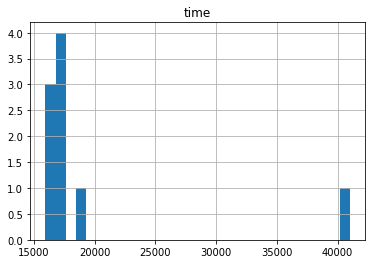

In [261]:
movie[0:9].hist(bins=30)
movie[0:9]['movie']